In [1]:
%matplotlib inline
#
from lrgsglib.core import *
# from lrgsglib.Ccore.statsys.RBIsingM.storer import ising_model_store
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
datpath = os.path.join('data')
Isingdatapath = os.path.join('devTools', 'RBIsingM')
plotpath = os.path.join(datpath, Isingdatapath, 'plot', '')
os.makedirs(plotpath, exist_ok=True)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


### Ising overlap giant cluster $\langle m_\infty\rangle$

In [2]:
side = 32
geo = 'squared'
pflip = 0.25
gsN = 0
cell = 'rand'
ic = 'ground_state_0'
in_suffix = f"p={pflip:.3g}_{cell}"
out_suffix = 'testC1'

In [3]:
l = Lattice2D(side1=side, sgpath=Isingdatapath, geo=geo, pflip=pflip,
            init_nw_dict=True, seed=0)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(howmany=10)
l.export_edgel_bin(expoName=in_suffix)
for T in np.linspace(0.1, 3, 10):
    for navg in range(20):
        isdy = IsingDynamics(l, T, ic=ic, runlang='C1', NoClust=1, rndStr=False,
                     out_suffix=out_suffix, in_suffix=in_suffix)
        isdy.init_ising_dynamics()
        isdy.export_ising_clust()
        isdy.run(verbose=True)

Executing:  ./src/lrgsglib/Ccore/bin/IsingSimulator1 1024 3 0.25 p=0.25_rand 1 2 10 data/devTools/RBIsingM/l2d_squared/ testC1 asynchronous 10 100

In [5]:
path = "/home/opisthofulax/PhD/projects/complex-networks/lrgsglib/data/devTools/RBIsingM/l2d_squared/ising/N=1024/"
dat = {T: np.loadtxt(fname)
       for T in np.linspace(0.1, 3, 20) if os.path.exists(fname := os.path.join(path, f"outcl0_p={pflip:.3g}_{cell}_T={T:.3g}_testC1.txt"))}

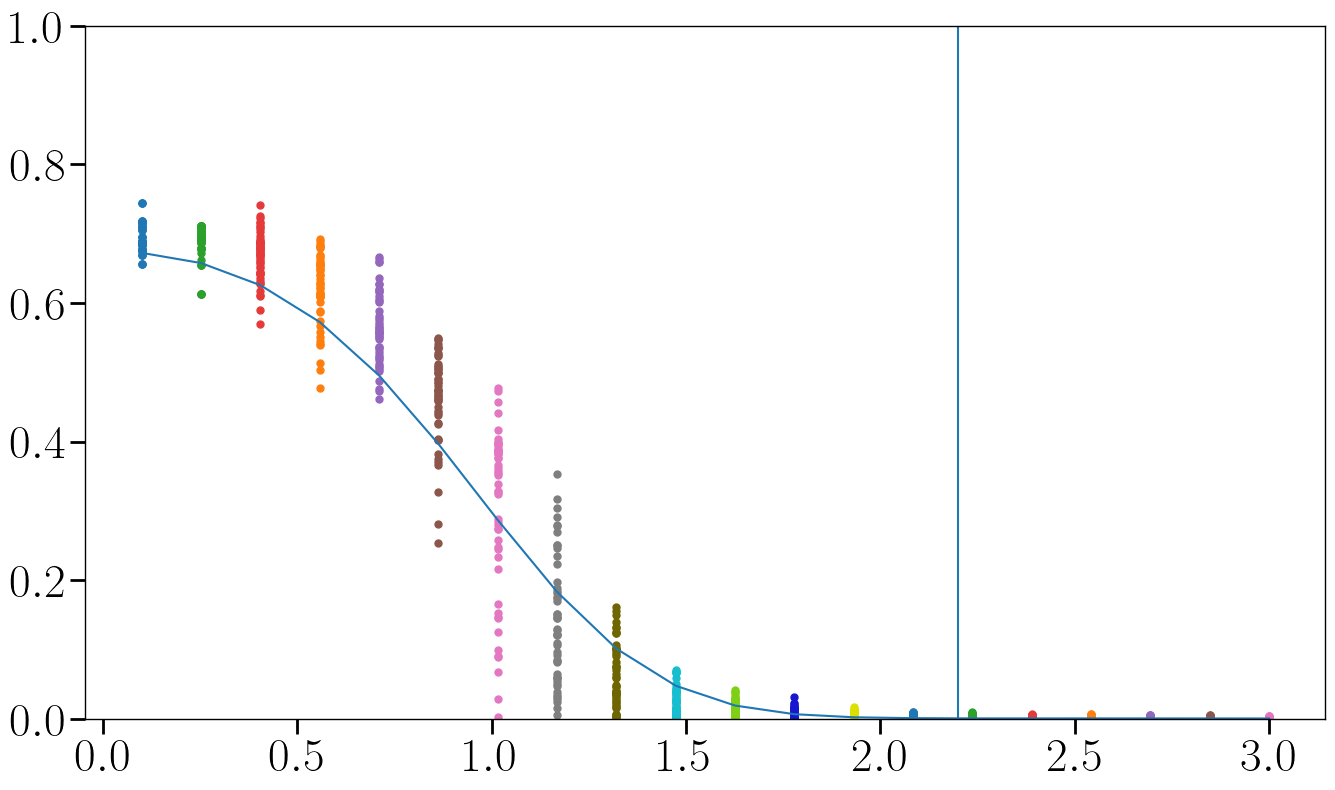

In [6]:
average_points = []
for T in np.linspace(0.1, 3, 20):
    try:
        points = dat[T][:, 0]
        plt.scatter([T] * len(points), np.abs(points), label=f'T={T:.1f}')
        average_points.append([T, np.mean(points)])
    except:
        pass
average_points = np.array(average_points)
plt.plot(average_points[:, 0], gaussian_filter1d(np.abs(average_points[:, 1]), sigma=2), '-')
plt.ylim(0, 1)
plt.axvline(2.2)

- we can make the plot of the 2d surface in the phase space p-T-m

### Simulated Annealing Reverse (local minima stability test)

In [ ]:
side = 32
geo = 'squared'
pflip = 0.25
gsN = 0
IMPORT = False
args = {'import_on': True} if IMPORT else {}
T_0 = 0.1
T_F = 2.2

In [ ]:
l = Lattice2D(side1=side, sgpath=Isingdatapath, geo=geo, pflip=pflip,
            init_nw_dict=True, seed=0, **args)
l.flip_sel_edges(l.nwDict['rand']['G'])
l.compute_k_eigvV(howmany=10)
if not l.import_on:
    l.export_edgel_bin()
#
ising_dyn = IsingDynamics(sg=l, ic=f"custom", runlang="C2")
#
kwargsImshow = dict(cmap='gray', origin='lower')
for T in np.linspace(T_0, T_F, num=8):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ising_dyn.init_ising_dynamics(custom=l.bin_eigV(), randstring_OPT=False)
    ax[0].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    ising_dyn.run(T_ising=T, thrmSTEP=4, eqSTEP=8, out_suffix="test_sa")
    ax[1].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    ising_dyn.export_s_init()
    ising_dyn.run(T_ising=T_0, thrmSTEP=4, eqSTEP=0, out_suffix=f"cool={T:.3g}")
    ax[2].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    for axx in ax:
        axx.axis('off')
    ax[0].set_title(fr"$T = {T_0:.3g}$")
    ax[1].set_title(fr"$T = {T:.3g}$")
    ax[2].set_title(fr"$T = {T_0:.3g}$")
    fig.savefig(os.path.join(plotpath, f"IsingDyn_T={T:.3g}.png"),
                bbox_inches='tight')
    plt.close('all')

### C implementation (IsingDynamics `class`)

- Note that the higher eigenstates of laplacian in ising (plane waves of higher orders) are persistent states of the dynamics!

In [ ]:
side = 64
geo = 'squared'
pflip = 0.5
T_ising = 1
navg = 2
eqSTEP = 10
gsN = 0
#
IMPORT = False

In [ ]:
args = {'import_on': True} if IMPORT else {}
l = Lattice2D(side1=side, geo=geo, pflip=pflip, init_nw_dict=True, **args)
# l.flip_random_fract_edges()
l.flip_sel_edges(l.nwDict['randXERR']['G'])
l.compute_k_eigvV(howmany=20)
ising_dyn = IsingDynamics(sg=l, T=T_ising, 
                          nstepsIsing=1000, 
                          ic=f"ground_state_{gsN}",
                          runlang="C2")
ising_dyn.init_ising_dynamics()
if not l.import_on:
    # l.export_graph()
    l.export_edgel_bin()

In [ ]:
ising_dyn.run()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
s_imshow = flip_to_positive_majority_adapted(ising_dyn.s.reshape(l.syshape))
eigv_show = flip_to_positive_majority_adapted(np.sign(l.eigV[gsN].reshape(l.syshape)))
ax[0].imshow(s_imshow, interpolation='none')
ax[1].imshow(eigv_show, interpolation='none')
ax[2].imshow(np.fromfile(f'data/l2d_squared/ising/N={side**2}/s_sqr_p={pflip:.3g}.bin', dtype="int8").reshape(l.syshape), interpolation='none')

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=2)
path = f"data/l2d_squared/ising/N={l.N}/s_sqr_p={pflip:.3g}.bin"
a = np.fromfile(path, dtype="int8").reshape(*l.syshape)
path = f"data/l2d_squared/ising/N={l.N}/sOut_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin"
b = np.fromfile(path, dtype="int8").reshape(-1, *l.syshape)
a = flip_to_positive_majority_adapted(a)
b = flip_to_positive_majority_adapted(b)
overlap = np.sum(a == b[-1]) / l.N
print(overlap)
ax.imshow(a-b[-1])
c = flip_to_positive_majority_adapted(np.sign(l.eigV[4].reshape(l.syshape)))
overlap = np.sum(c == b[-1]) / l.N
print(overlap)
ax1.imshow(c-b[-1])

In [ ]:
# here we need to set g_ferro nodes the attribute "ferro" and viceversa
l.load_vec_on_nodes(b[-1].flatten(), attr='s')
ferroGroup, antiGroup = l.classify_ferroAntiferro_regions()

In [ ]:
def substitute_values(matrix, values, val = -1):
    values_set = values
    flat_matrix = matrix.flatten()
    substituted_flat_matrix = np.where(np.isin(flat_matrix, values_set), val, flat_matrix)
    substituted_matrix = substituted_flat_matrix.reshape(matrix.shape)
    return substituted_matrix

In [ ]:
cc = np.array(list(l.G.nodes())).reshape(l.syshape)
dd = substitute_values(cc, antiGroup)
dd = substitute_values(dd, ferroGroup, val=1)

In [ ]:
len(ferroGroup), len(antiGroup), len(ferroGroup) + len(antiGroup), 

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(a, cmap='gray')
# ax.imshow(dd, alpha=.7)
fig.colorbar(im)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
im1 = ax[0].imshow(c)
im2 = ax[1].imshow(b[-1])
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=len(b)//5, figsize=(12, 4))
for i in range(len(b)//5):
    for j in range(5):
        ax[i][j].imshow(b[i*5+j], interpolation='none', cmap='hot')
        ax[i][j].axis('off')

In [ ]:
path = f"data/l2d_squared/ising/N={l.N}/ene_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin"
ene = np.fromfile(path, dtype="float")
path = f"data/l2d_squared/ising/N={l.N}/magn_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin"
magn = np.fromfile(path, dtype="float")
pflip, T_ising

In [ ]:
x = np.linspace(1, len(ene), len(ene))
plt.plot(x, ene/4)
plt.plot(x, magn)
plt.xscale("log")
plt.ylim(-1.05, 1.05)

### Energy levels

In [ ]:
side = 48
geo = 'squared'
pbc = True
pflip = 0.1
howmany = 100
cmap = restr_twilight

In [ ]:
l = Lattice2D(side, geo, pbc=pbc, pflip=pflip)
# np.random.seed(1)
# random.seed(1)
# l.flip_sel_edges()
l.flip_random_fract_edges()
l.compute_k_eigvV(howmany=howmany, MODE_dynspec="scipy")
energies = np.array([-l.compute_rbim_energy_eigV(_)/(2*l.N) for _ in range(howmany)])
en0 = np.max(np.abs(energies))

In [ ]:
fig, (ax, ax1) = plt.subplots(figsize=(10, 7), ncols=2, width_ratios=[1, 1])

ylabelPos = []
xlabelPos = []

y_min, y_max = min(energies), max(energies)
y_range = y_max - y_min
thresh = 0.05
threshold = y_range * thresh  # Adjust the fraction as needed

for i, en in enumerate(energies):
    color = cmap(i / len(energies)) if i != 0 else 'red'
    text_x = 1
    text_y = en
    if ylabelPos and any(abs(text_y - pos) < threshold for pos in ylabelPos):
        indices = [i for i, pos in enumerate(ylabelPos) 
                   if abs(text_y - pos) < threshold]
        index = max(indices, key=lambda i: xlabelPos[i])
        text_x = xlabelPos[index] +.3
    ax.axhline(en, 0.05, 1-0.05, lw=4, color=color, zorder=len(energies)-i+1)
    ax1.axhline(np.abs(l.eigv[i]), 0.05, 1-0.05, lw=4, color=color, zorder=len(energies)-i+1)
    # ax.text(text_x+.05, text_y, fr'$E(|\lambda_{{{i}}}\rangle)$', 
    #          va='center', ha='left', fontsize=16, color=color)
    ylabelPos.append(text_y)
    xlabelPos.append(text_x)


# Customize the axes to remove the top and right box
for axx in [ax, ax1]:
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.yaxis.set_ticks_position('left')
    axx.xaxis.set_ticks_position('bottom')
    axx.spines['left'].set_position(('outward', 10))
    axx.spines['bottom'].set_position(('outward', 10))
    axx.grid(True)


fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(energies))), ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(l.eigv))), ax=ax1)

# x, pdf = powerlaw.pdf(np.abs(l.eigV[0]))
# ax1.loglog(x[1:], pdf, 'k-', lw=2)
# ax1.axvline(np.finfo(float).eps, color='red', lw=2)

In [ ]:
replicas = 100

In [ ]:
def compute_overlap(matrix1, matrix2):
    return np.dot(matrix1.flatten(), matrix2.flatten()) / matrix1.size
eigV = []
l = Lattice2D(side, geo, pbc=pbc, pflip=pflip)
for i in range(replicas):
    l.flip_random_fract_edges()
    l.compute_k_eigvV(howmany=1, MODE_dynspec="numpy")
    eigV.append(l.eigV[0].reshape(l.syshape))
# Compute all pairs of overlaps
overlaps = []
for i in range(replicas):
    for j in range(i + 1, replicas):
        q = compute_overlap(eigV[i], eigV[j])
        overlaps.append(q)

In [ ]:
LRGSG_LIB_CBIN

### C++ attempt (slow)

In [ ]:
temperature = 1
pflip = 0
side = 50
pbc=True
geo = 'squared'
navg = 5
steps = side**2
frameRate = 1
single_mode = True

In [ ]:
l = Lattice2D(side, geo=geo, pflip=pflip, pbc=pbc)
#
l.flip_random_fract_edges()
edgeList = list(l.GraphReprDict['H'].edges())
nodeList = l.nodeList
signs = list(l.GraphReprDict['H'].edges(data='weight'))

In [ ]:
if single_mode:
#
    model = ising_model_store.IsingModel(edgeList, signs, side, side, 
                                            temperature, "asynchronous")
    model.simulate(steps, frameRate)
    ene = np.array(model.getFrameEnergies())
else: 
    magn = []
    ene = []
    for _ in range(navg):
        model = ising_model_store.IsingModel(edgeList, signs, side, side, 
                                            temperature, "asynchronous")
        model.simulate(steps, frameRate)
        magn.append([model.getFrameMagnetizations()])
        ene.append([model.getFrameEnergies()])

In [ ]:
for en in ene:
    tt = en[0]
    eneNorm = tt
    plt.plot(np.linspace(1, len(eneNorm), num=len(eneNorm)), eneNorm, '-')
# plt.plot(magn, 'h')
plt.xscale('log')
